# CIS519 Project - Cassava Leaf Image Classification


## Run All Hyper Param

Warning: run all may lose data. Be cautious

In [36]:
redo_data_clean = False
need_retrain = True

## Setup

In [38]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go

import time
from datetime import datetime
import os
import io
import boto3
from io import BytesIO
import sagemaker
from sagemaker import get_execution_role

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url
import torchvision as tv
import torchvision.transforms as T
import torchvision.models as M
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, IterableDataset, random_split
from PIL import Image
import random
from tqdm import tqdm

from torch.cuda.amp import autocast, GradScaler
from datetime import datetime
import pytz

In [3]:
%%time

role = get_execution_role()
print(role)

region = boto3.Session().region_name
sess = sagemaker.Session()

arn:aws:iam::968333200412:role/SageMakerExecutionRole
CPU times: user 267 ms, sys: 18.6 ms, total: 285 ms
Wall time: 368 ms


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### S3 connection

In [5]:
s3_client = boto3.client('s3')

# List all the buckets
response = s3_client.list_buckets()

# Print the name of each bucket
for bucket in response['Buckets']:
    print(bucket['Name'])
    bucket_name = bucket['Name']

# List all the folders (prefixes) inside the bucket
response = s3_client.list_objects_v2(Bucket=bucket_name, Delimiter='/')

# Print the name of each folder
for content in response.get('CommonPrefixes', []):
    print(content.get('Prefix'))

519bucket
dataset-backup/
dataset-latest/
dataset/


In [6]:
file_path = 'dataset/train.csv'
train_csv_obj = s3_client.get_object(Bucket=bucket_name, Key=file_path)
train_df =pd.read_csv(io.BytesIO(train_csv_obj['Body'].read()))
train_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [7]:
#count the total number of images 
csv_image_count = train_df['image_id'].count()
display(csv_image_count)

#check the file amount inside train_images folder
folder_path = 'dataset/train_images'

def count_files_in_s3_folder(bucket, prefix):
    paginator = s3_client.get_paginator('list_objects_v2')
    count = 0

    for page in paginator.paginate(Bucket=bucket, Prefix=prefix):
        for obj in page.get('Contents', []):
            if obj['Key'] != prefix:
                count += 1
                
    return count

number_of_files = count_files_in_s3_folder(bucket_name, folder_path)
print(f'There are {number_of_files} files in the folder {folder_path}.')


#check if they are the same
if csv_image_count == number_of_files:
    #show a green light symbol
    display("✅, all images are uploaded.")
else:
    #show a red light symbol
    display("❌, partial uploaded, missing images.")

21397

There are 9729 files in the folder dataset/train_images.


'❌, partial uploaded, missing images.'

### Data clean

**Since the upload speed for S3 would decrease like gradient, we are not able to obtain all train images. Hence here we do a data pre cleaning**


In [9]:
if need_clean:
    new_train_df = train_df.copy()
    for index, row in tqdm(train_df.iterrows(), total=train_df.shape[0]):
        file_path = 'dataset/train_images/' + row['image_id']
        try:
            s3_client.head_object(Bucket=bucket_name, Key=file_path)
        except:
            new_train_df = new_train_df.drop(index)

    new_count = new_train_df['image_id'].count()
    display(new_count)
    new_train_df.head()
    
    clean_train_df = new_train_df.copy()
    #add time step to the file name
    clean_train_df.to_csv('clean_train_df_{}.csv'.format(time.time()), index=False)
    # show the label distribution in train
    clean_train_df['label'].value_counts().plot(kind='bar')

## EDA

In [10]:
read_file_from_s3 = lambda file_path: s3_client.get_object(Bucket=bucket_name, Key=file_path)['Body']

pd.read_csv(read_file_from_s3('dataset/train.csv'))

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


,image_id,label
0,2216849948.jpg,4


,0
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


<AxesSubplot:>

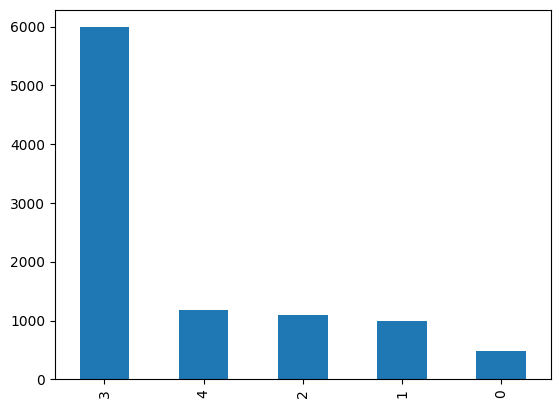

In [11]:
# Print labels and category encodings
path_prefix = 'dataset/'

# Load data
train = pd.read_csv('clean_train_df.csv')
test = pd.read_csv(read_file_from_s3('dataset/sample_submission.csv'))
label_map = pd.read_json(read_file_from_s3('dataset/label_num_to_disease_map.json'), orient='index')

# Print labels and category encodings
display(train.head())
display(test.head())
display(label_map)

# show the label distribution in train
train['label'].value_counts().plot(kind='bar')

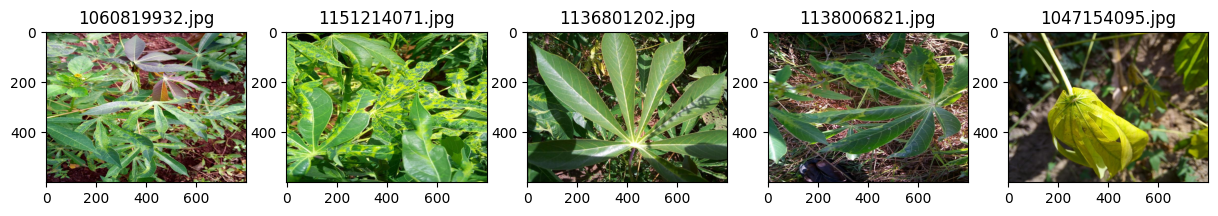

In [12]:
# Visualize raw images
image_dir = path_prefix + 'train_images/'

s3 = boto3.client('s3')
s3_objects = s3.list_objects_v2(Bucket=bucket_name, Prefix=image_dir)['Contents']
image_files = [obj['Key'] for obj in s3_objects]
num_images = 5
sample_images = random.sample(image_files, num_images)
fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
for i, image_file in enumerate(sample_images):
    image_bytes = read_file_from_s3(image_file)
    image = Image.open(image_bytes)
    axs[i].imshow(image)
    image_file_short = image_file.replace(image_dir, '')
    axs[i].set_title(image_file_short)
plt.show()

### DataSet

In [13]:
# Define basic transformation and augmentation
transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])

class CassavaDataset(Dataset):
    def __init__(self, csv_path, s3_prefix, transform=None):
        self.data = pd.read_csv(csv_path)
        self.s3_prefix = s3_prefix
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        row = self.data.iloc[index]
        image_path = f"{self.s3_prefix}/{row['image_id']}"
        #now doing good thing
        image_bytes = read_file_from_s3(image_path)
        image = Image.open(image_bytes).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        label = row['label']
        return image, label
        
train_data_path = 'clean_train_df.csv'
s3_prefix = 'dataset/train_images'
dataset = CassavaDataset(train_data_path, s3_prefix, transform=transform)

## 1. Baseline

### 1.1 Implementation (Ruichen)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


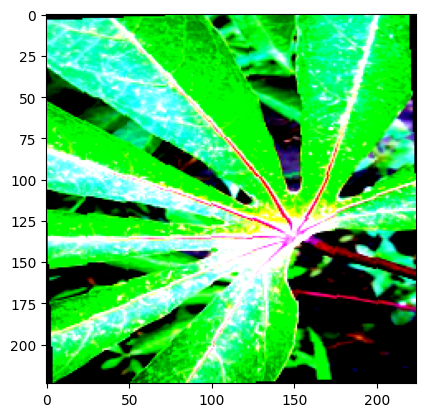

In [15]:
# Visualize transformed image
img_id = train.sample(1)['image_id'].values[0]
sample_image_path = path_prefix + 'train_images/'+ img_id
sample_image = Image.open(read_file_from_s3(sample_image_path))
transformed_image = transform(sample_image)

plt.imshow(transformed_image.permute(1, 2, 0))
plt.show()

In [16]:
# Train test split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Load data
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [17]:
print(torchvision.models.resnet.__all__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

['ResNet', 'ResNet18_Weights', 'ResNet34_Weights', 'ResNet50_Weights', 'ResNet101_Weights', 'ResNet152_Weights', 'ResNeXt50_32X4D_Weights', 'ResNeXt101_32X8D_Weights', 'ResNeXt101_64X4D_Weights', 'Wide_ResNet50_2_Weights', 'Wide_ResNet101_2_Weights', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'resnext50_32x4d', 'resnext101_32x8d', 'resnext101_64x4d', 'wide_resnet50_2', 'wide_resnet101_2']
cuda


In [37]:
if need_retrain:
    # Set the timezone to Pacific Time
    pt = pytz.timezone('America/Los_Angeles')

    # Get the current time in Pacific Time
    current_time = datetime.now(pt)
    # Define baseline model
    resnet = M.resnet18(pretrained=True)
    num_classes = 5
    num_ftrs = resnet.fc.in_features
    resnet.fc = nn.Linear(num_ftrs, num_classes)
    resnet.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

    # Initialize GradScaler
    scaler = GradScaler()

    # Train baseline model (or more accurately, fine-tune the pre-trained model to apply on our specific dataset)
    num_epochs = 10
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in tqdm(enumerate(train_loader), total = len(train_loader)):
            inputs = inputs.to(device) # Moved input data to the GPU
            labels = labels.to(device) # Moved target labels to the GPU

            optimizer.zero_grad()

            # Use autocast to perform automatic mixed precision training
            with autocast():
                outputs = resnet(inputs)
                loss = criterion(outputs, labels)

            # Scales the loss to avoid underflow or overflow
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            if i % 100 == 99:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0

/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 21%|██        | 100/487 [01:00<03:56,  1.64it/s]

[1,   100] loss: 1.009


 41%|████      | 200/487 [02:02<02:32,  1.88it/s]

[1,   200] loss: 0.770


 61%|██████▏   | 299/487 [03:06<01:58,  1.59it/s]

[1,   300] loss: 0.780


 82%|████████▏ | 399/487 [04:12<00:56,  1.55it/s]

[1,   400] loss: 0.690


 21%|██        | 100/487 [01:00<03:14,  1.99it/s]

[2,   100] loss: 0.564


 41%|████      | 200/487 [02:06<02:50,  1.69it/s]

[2,   200] loss: 0.572


 61%|██████▏   | 299/487 [03:09<01:52,  1.68it/s]

[2,   300] loss: 0.581


 82%|████████▏ | 399/487 [04:15<00:57,  1.52it/s]

[2,   400] loss: 0.584


 20%|██        | 99/487 [00:58<03:51,  1.68it/s]

[3,   100] loss: 0.500


 41%|████      | 199/487 [02:01<02:58,  1.62it/s]

[3,   200] loss: 0.468


 62%|██████▏   | 300/487 [03:03<01:53,  1.64it/s]

[3,   300] loss: 0.518


 82%|████████▏ | 400/487 [04:09<01:03,  1.37it/s]

[3,   400] loss: 0.476


 21%|██        | 100/487 [00:55<03:33,  1.82it/s]

[4,   100] loss: 0.414


 41%|████      | 199/487 [01:52<02:52,  1.67it/s]

[4,   200] loss: 0.442


 61%|██████▏   | 299/487 [02:49<01:52,  1.68it/s]

[4,   300] loss: 0.412


 82%|████████▏ | 400/487 [03:50<00:52,  1.67it/s]

[4,   400] loss: 0.390


 21%|██        | 100/487 [00:52<03:36,  1.79it/s]

[5,   100] loss: 0.372


 41%|████      | 200/487 [01:45<02:35,  1.85it/s]

[5,   200] loss: 0.344


 61%|██████▏   | 299/487 [02:40<01:39,  1.88it/s]

[5,   300] loss: 0.379


 82%|████████▏ | 399/487 [03:35<00:49,  1.78it/s]

[5,   400] loss: 0.376


 20%|██        | 99/487 [00:50<03:27,  1.87it/s]

[6,   100] loss: 0.304


 41%|████      | 199/487 [01:42<02:26,  1.97it/s]

[6,   200] loss: 0.338


 61%|██████▏   | 299/487 [02:36<01:43,  1.81it/s]

[6,   300] loss: 0.296


 82%|████████▏ | 399/487 [03:30<00:46,  1.90it/s]

[6,   400] loss: 0.343


 20%|██        | 99/487 [00:49<03:14,  1.99it/s]

[7,   100] loss: 0.298


 41%|████      | 199/487 [01:41<02:28,  1.94it/s]

[7,   200] loss: 0.259


 61%|██████▏   | 299/487 [02:32<01:41,  1.85it/s]

[7,   300] loss: 0.261


 82%|████████▏ | 400/487 [03:26<00:47,  1.85it/s]

[7,   400] loss: 0.281


 21%|██        | 100/487 [00:46<03:18,  1.95it/s]

[8,   100] loss: 0.233


 41%|████      | 199/487 [01:36<02:24,  1.99it/s]

[8,   200] loss: 0.244


 61%|██████▏   | 299/487 [02:25<01:31,  2.06it/s]

[8,   300] loss: 0.253


 82%|████████▏ | 399/487 [03:16<00:49,  1.77it/s]

[8,   400] loss: 0.261


 21%|██        | 100/487 [00:45<03:02,  2.12it/s]

[9,   100] loss: 0.204


 41%|████      | 199/487 [01:33<02:21,  2.04it/s]

[9,   200] loss: 0.191


 62%|██████▏   | 300/487 [02:21<01:23,  2.24it/s]

[9,   300] loss: 0.193


 82%|████████▏ | 400/487 [03:11<00:43,  2.00it/s]

[9,   400] loss: 0.216


 20%|██        | 99/487 [00:43<02:51,  2.26it/s]

[10,   100] loss: 0.142


 41%|████      | 200/487 [01:29<02:04,  2.31it/s]

[10,   200] loss: 0.182


 62%|██████▏   | 300/487 [02:16<01:30,  2.06it/s]

[10,   300] loss: 0.183


 82%|████████▏ | 400/487 [03:07<00:43,  1.98it/s]

[10,   400] loss: 0.178


100%|██████████| 487/487 [03:51<00:00,  2.10it/s]


In [39]:
timestamp = current_time.strftime('%H:%M')
# Print the current time
print("Current Pacific Time:", timestamp)

model_path = f"models/resnet18-{timestamp}.pth"
torch.save(resnet.state_dict(), model_path)

Current Pacific Time: 20:03


Now Model is saved under models/ folder. We can load the model and test any time

### 1.2 Evalutation (Alan)

#### TODO

Test on test_loader, and evaluate the model performance:
- Use a table to record accuracy, precision, recall, F1 score
- Draw confusion matrix, precision-recall curve
- Draw AUC-ROC figure

In [ ]:
## SAMPLE CODE, NOT TESTED
resnet.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print('Test Accuracy: {:.2f}%'.format(accuracy * 100))

## 2. Fine-tuning Kaggle Solution

### 2.1 Implementation (Qihang)

#### Base VIT Model

basic data load, seed and transform adpot from [here](https://www.kaggle.com/code/abhinand05/vision-transformer-vit-tutorial-baseline/notebook#notebook-container)


In [40]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False


seed_everything(1001)

import torchvision.transforms as transforms

IMG_SIZE = 224

transforms_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

transforms_valid = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

In [41]:
import timm
print("Available Vision Transformer Models: ")
timm.list_models("vit*")

Available Vision Transformer Models: 


['vit_base_patch8_224',
 'vit_base_patch8_224_dino',
 'vit_base_patch8_224_in21k',
 'vit_base_patch16_18x2_224',
 'vit_base_patch16_224',
 'vit_base_patch16_224_dino',
 'vit_base_patch16_224_in21k',
 'vit_base_patch16_224_miil',
 'vit_base_patch16_224_miil_in21k',
 'vit_base_patch16_224_sam',
 'vit_base_patch16_384',
 'vit_base_patch16_plus_240',
 'vit_base_patch16_rpn_224',
 'vit_base_patch32_224',
 'vit_base_patch32_224_clip_laion2b',
 'vit_base_patch32_224_in21k',
 'vit_base_patch32_224_sam',
 'vit_base_patch32_384',
 'vit_base_patch32_plus_256',
 'vit_base_r26_s32_224',
 'vit_base_r50_s16_224',
 'vit_base_r50_s16_224_in21k',
 'vit_base_r50_s16_384',
 'vit_base_resnet26d_224',
 'vit_base_resnet50_224_in21k',
 'vit_base_resnet50_384',
 'vit_base_resnet50d_224',
 'vit_giant_patch14_224',
 'vit_giant_patch14_224_clip_laion2b',
 'vit_gigantic_patch14_224',
 'vit_huge_patch14_224',
 'vit_huge_patch14_224_clip_laion2b',
 'vit_huge_patch14_224_in21k',
 'vit_large_patch14_224',
 'vit_large_

#### VIT Model

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [43]:
print(torch.__version__)

1.13.1+cu117


In [44]:
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm

class VitClassifier(nn.Module):
    def __init__(self, model_name="vit_base_patch16_224", n_classes=5, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.head.in_features
        self.model.head = nn.Linear(n_features, n_classes)
        
        self.best_val_loss = float('inf')  # initialize best validation loss to infinity
        self.early_stopping_rounds = 3  # number of epochs to wait before early stopping
        self.epochs_without_improvement = 0  # number of epochs without improvement
        
        self.scaler = GradScaler()  # initialize GradScaler
    
    def forward(self, x):
        x = self.model(x)
        return x
    
    def evaluate(self, loader, criterion, device):
        self.model.eval()
        val_loss = 0
        val_acc = 0
        with torch.no_grad():
            for data, target in loader:
                data, target = data.to(device), target.to(device)
                output = self.model(data)
                val_loss += criterion(output, target).item()
                val_acc += (output.argmax(1) == target).sum().item()

        val_loss /= len(loader)
        val_acc /= len(loader.dataset)
        return val_loss, val_acc
    
    def train_one(self, loader, optimizer, criterion, device, val_loader=None):
        self.model.train()
        train_loss = 0
        train_acc = 0
        pbar = tqdm(enumerate(loader), total=len(loader))
        for step, batch in pbar:
            optimizer.zero_grad()
            data, target = batch
            data, target = data.to(device), target.to(device)
            
            output = self.model(data)
            loss = criterion(output, target)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_acc += (output.argmax(1) == target).sum().item()
        
        train_loss /= len(loader)
        train_acc /= len(loader.dataset)
        
        if val_loader is not None:
            val_loss, val_acc = self.evaluate(val_loader, criterion, device)
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.epochs_without_improvement = 0
            else:
                self.epochs_without_improvement += 1
        
        if self.epochs_without_improvement >= self.early_stopping_rounds:
            print(f'Validation loss has not improved in {self.early_stopping_rounds} epochs. Early stopping...')
            return train_loss, train_acc, True
        else:
            return train_loss, train_acc, False

In [ ]:
model = VitClassifier(model_name="vit_base_patch16_224", n_classes=5, pretrained=True)

torch.cuda.empty_cache()

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

criterion = nn.CrossEntropyLoss()

batch_size_vit = 16
num_workers = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size_vit, shuffle=True, num_workers = num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size_vit, shuffle=True, num_workers = num_workers)


def train(model, optimizer, criterion, train_loader, val_loader, device, epochs=4):
    current_time = datetime.now(pt)
    timestamp = current_time.strftime('%H:%M')
    print(f"total train epochs: {epochs}")
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    start_time = time.time()
    for epoch in range(epochs):
        print(f"Epoch: {epoch + 1}  / {epochs}")
        train_loss, train_acc, early_stopping = model.train_one(train_loader, optimizer, criterion, device)
        val_loss, val_acc = model.evaluate(val_loader, criterion, device)
        print(f"Epoch: {epoch + 1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
    torch.save(model.state_dict(), f"models/vit_{timestamp}_epoch_{epoch}.pth")
    time_elapsed = time.time() - start_time
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    return train_losses, train_accs, val_losses, val_accs
if need_retrain:
    train_losses, train_accs, val_losses, val_accs = train(model, optimizer, criterion, train_loader, test_loader, device, epochs=10)

total train epochs: 10
Epoch: 1  / 10


100%|██████████| 487/487 [05:15<00:00,  1.54it/s]


Epoch: 1 | Train Loss: 2.4999 | Train Acc: 0.5369 | Val Loss: 1.3344 | Val Acc: 0.6115
Epoch: 2  / 10


100%|██████████| 487/487 [05:13<00:00,  1.55it/s]


Epoch: 2 | Train Loss: 1.2144 | Train Acc: 0.6162 | Val Loss: 1.2414 | Val Acc: 0.6115
Epoch: 3  / 10


100%|██████████| 487/487 [05:18<00:00,  1.53it/s]


Epoch: 3 | Train Loss: 1.1985 | Train Acc: 0.6161 | Val Loss: 1.2060 | Val Acc: 0.6115
Epoch: 4  / 10


100%|██████████| 487/487 [04:58<00:00,  1.63it/s]


In [ ]:
current_time = datetime.now(pt)
timestamp = current_time.strftime('%H:%M')

# Save model with timestamp
torch.save(model.state_dict(), f"models/vit_{timestamp}.pth")

# Create pandas DataFrame with training/validation results
df = pd.DataFrame({
    'train_loss': train_losses, 
    'train_acc': train_accs, 
    'val_loss': val_losses, 
    'val_acc': val_accs
})

# Save CSV with timestamp
df.to_csv(f"vit_loss_{timestamp}.csv", index=False)

### 2.2 Evaluation (Alan)

#### TODO

Test on test_loader, and evaluate the model performance:
- Use a table to record accuracy, precision, recall, F1 score
- Draw confusion matrix, precision-recall curve
- Draw AUC-ROC figure